In [1]:
#from pycocotools.coco import COCO
import sys
import os
sys.path.append('/root/pva-faster-rcnn/lib')
sys.path.append('/root/pva-faster-rcnn/lib/datasets')
sys.path.append('/root/pva-faster-rcnn/tools')
import glob
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect,get_layer_name
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, cv2
import argparse
import json
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list
from datasets.config import CLASS_SETS
from datasets.vatic_hierarchy import VaticData, IMDBGroup
from datasets.openImage import openImageData
#from datasets.vatic import VaticData, IMDBGroup
import random
from scipy.misc import imread
import re
import timeit
import csv

In [6]:
def detect(CLASSES,net,img,threshold):
    im = cv2.imread(img)
    NMS_THRESH = 0.3
    _t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
    scores,boxes = im_detect(net,im,_t)
    res = [] 
    for cls_ind, cls in enumerate(CLASSES[1:]):
        #print cls_ind
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        thresh = 0
        inds = np.where(dets[:, -1] > thresh)[0]
        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]*100
            #Fix bug 6
            x = bbox[0]
            y = bbox[1]
            width = bbox[2] - bbox[0]
            height =  bbox[3] - bbox[1]
            label = cls
            socre = bbox[-1] * 100
            if score > threshold:
                res.append([img, x, y, width, height, score, label])

    return res

def processClass(cls_order,cls_mapper):
    tempCls=[]
    for i in cls_order:
        if cls_mapper.has_key(i):
            if cls_mapper.get(i) not in tempCls:
                tempCls.append(cls_mapper.get(i))
        elif i not in tempCls:
            tempCls.append(i)
    return tempCls

def vocAp(rec,prec):
    rec.insert(0,0.0)
    rec.append(1.0)
    mrec = rec[:]
    prec.insert(0,0.0)
    prec.append(0.0)
    mpre = prec[:]
    for i in range(len(mpre)-2,-1,-1):
        mpre[i] = max(mpre[i],mpre[i+1])
    iList = []
    for i in range(1,len(mrec)):
        if mrec[i] != mrec[i-1]:
            iList.append(i)
            
    ap = 0.0
    for i in iList:
        ap+=((mrec[i]-mrec[i-1])*mpre[i])
    return ap,mrec,mpre





def evaluate(modelName,iteration,cls_order,cls_mapper,gpu_id,testSets,datasetName="openImages_v4"):
    imgIdx = []
    GT = []
    CLASSES = processClass(cls_order,cls_mapper)
    name = "eval"
    for target in testSets:
        dataset = openImageData(name,cls_order,cls_mapper,sets=target)
        for i in dataset._image_index:
            target_img = "/root/data/data-{}/{}/{}.jpg".format(datasetName,target,i)
            imgIdx += [target_img]
            label = dataset._load_boxes(i)['gt_classes']
            bbox = dataset._load_boxes(i)['boxes']
            for j,k in zip(label,bbox):
                GT.append(([target_img,k[0],k[1],k[2],k[3],CLASSES[j]]))
    GTdata = {}
    gtCounterPerCls = {}
    for re in GT:
        if gtCounterPerCls.has_key(re[5]):
            gtCounterPerCls[re[5]]+=1
        else:
            gtCounterPerCls[re[5]] = 1
        hit = {"label":re[5],"bbox":[x for x in re[1:5]],"used":False}
        if GTdata.has_key(re[0]):
            GTdata.get(re[0]).append(hit)
        else:
            GTdata[re[0]] = []
            GTdata.get(re[0]).append(hit)   
    weightPath = "/root/pva-faster-rcnn/models/output/{}/{}_iter_{}.caffemodel".format(modelName,modelName,str(iteration))
    modelPath = "/root/pva-faster-rcnn/models/pvanet/lite/{}_test.prototxt".format(modelName)
    print weightPath
    print modelPath
    caffe.set_mode_gpu()
    caffe.set_device(gpu_id)
    cfg_from_file("models/pvanet/cfgs/submit_0716.yml")
    cfg.GPU_ID = gpu_id
    det = {}
    totalImg = len(imgIdx)                       
    if not os.path.isfile(weightPath):
        raise IOError(('Caffemodel: {:s} not found').format(weightPath))
    net = caffe.Net(modelPath, weightPath, caffe.TEST)
    print '\n\nLoaded network {:s}'.format(modelPath)
    print "Total testing images: {}".format(len(imgIdx))
    for idx,targetImg in enumerate(imgIdx):
        timer = Timer()
        timer.tic()
        _t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
        res = detect(CLASSES,net,targetImg,15)
        timer.toc()
        print "Processing: {}/{},time usage is {:.3f}s".format(idx,totalImg,timer.average_time)
        for re in res:
            hit = {"confidence":re[5],"fileName":re[0],"bbox":[x for x in re[1:5]]}
            if det.has_key(re[6]):
                det.get(re[6]).append(hit)
            else:
                det[re[6]] = []
                det.get(re[6]).append(hit)             
    for i in CLASSES:
        if det.has_key(i) == False:
            det[i] = []
    return det,GTdata,gtCounterPerCls

In [11]:
CLASSES = ["__background__","Backpack", "Baseball bat", "Baseball glove", "Bag", "Man", "Woman", "Bicycle", "Gun", 
            "Gun", "Gun", "Suit", "Gun", "Dress", "Jacket", "Skirt", "Shorts", "Sports Uniform", "Shirt", 
            "Trousers", "Skirt",   "Glasses", "Glasses", "Headphones", "Sunglasses", "Hat", "Helmet", "Hat", 
            "Helmet", "Hat","Hat", "Roller skates", "Boot", "Handbag", "Backpack", "Suitcase", 
            "Bag", "Bag", "Wheelchair", "Umbrella", "Scarf", "Tie"]

Mapper = {'Rifle':'Gun','Handgun':'Gun','Shotgun':'Gun','Boy':'Man','Girl':'Woman',
              'Mini skirt':'Skirt','Goggles':'Glasses','Sunglasses':'Glasses','Sun hat':'Hat',
              'Football helmet':'Helmet','Cowboy hat':'Hat','Sombrero':'Hat','Handbag':'Bag',
              'Plastic bag':'Bag','Briefcase':'Bag'}
res,GTdata,gtCounterPerCls = evaluate("human0826",48000,CLASSES,Mapper,1,["validation"])

['__background__', 'Backpack', 'Baseball bat', 'Baseball glove', 'Bag', 'Man', 'Woman', 'Bicycle', 'Gun', 'Gun', 'Gun', 'Suit', 'Gun', 'Dress', 'Jacket', 'Skirt', 'Shorts', 'Sports Uniform', 'Shirt', 'Trousers', 'Skirt', 'Glasses', 'Glasses', 'Headphones', 'Sunglasses', 'Hat', 'Helmet', 'Hat', 'Helmet', 'Hat', 'Hat', 'Roller skates', 'Boot', 'Handbag', 'Backpack', 'Suitcase', 'Bag', 'Bag', 'Wheelchair', 'Umbrella', 'Scarf', 'Tie']
{'Boy': 'Man', 'Shotgun': 'Gun', 'Plastic bag': 'Bag', 'Cowboy hat': 'Hat', 'Briefcase': 'Bag', 'Sunglasses': 'Glasses', 'Football helmet': 'Helmet', 'Mini skirt': 'Skirt', 'Goggles': 'Glasses', 'Sombrero': 'Hat', 'Sun hat': 'Hat', 'Rifle': 'Gun', 'Handbag': 'Bag', 'Girl': 'Woman', 'Handgun': 'Gun'}
[None, '/m/01940j', '/m/03g8mr', '/m/03grzl', None, '/m/04yx4', '/m/03bt1vf', '/m/0199g', None, None, None, '/m/01xyhv', None, '/m/01d40f', '/m/032b3c', '/m/02wv6h6', '/m/01bfm9', None, '/m/01n4qj', '/m/07mhn', '/m/02wv6h6', '/m/0jyfg', '/m/0jyfg', '/m/01b7fy', '/

Processing: 160/5090,time usage is 0.145s
Processing: 161/5090,time usage is 0.153s
Processing: 162/5090,time usage is 0.093s
Processing: 163/5090,time usage is 0.141s
Processing: 164/5090,time usage is 0.099s
Processing: 165/5090,time usage is 0.167s
Processing: 166/5090,time usage is 0.109s
Processing: 167/5090,time usage is 0.157s
Processing: 168/5090,time usage is 0.163s
Processing: 169/5090,time usage is 0.112s
Processing: 170/5090,time usage is 0.077s
Processing: 171/5090,time usage is 0.178s
Processing: 172/5090,time usage is 0.138s
Processing: 173/5090,time usage is 0.100s
Processing: 174/5090,time usage is 0.150s
Processing: 175/5090,time usage is 0.136s
Processing: 176/5090,time usage is 0.109s
Processing: 177/5090,time usage is 0.088s
Processing: 178/5090,time usage is 0.150s
Processing: 179/5090,time usage is 0.157s
Processing: 180/5090,time usage is 0.132s
Processing: 181/5090,time usage is 0.081s
Processing: 182/5090,time usage is 0.154s
Processing: 183/5090,time usage is

Processing: 356/5090,time usage is 0.184s
Processing: 357/5090,time usage is 0.142s
Processing: 358/5090,time usage is 0.157s
Processing: 359/5090,time usage is 0.160s
Processing: 360/5090,time usage is 0.132s
Processing: 361/5090,time usage is 0.124s
Processing: 362/5090,time usage is 0.089s
Processing: 363/5090,time usage is 0.112s
Processing: 364/5090,time usage is 0.127s
Processing: 365/5090,time usage is 0.123s
Processing: 366/5090,time usage is 0.107s
Processing: 367/5090,time usage is 0.167s
Processing: 368/5090,time usage is 0.117s
Processing: 369/5090,time usage is 0.111s
Processing: 370/5090,time usage is 0.116s
Processing: 371/5090,time usage is 0.121s
Processing: 372/5090,time usage is 0.146s
Processing: 373/5090,time usage is 0.108s
Processing: 374/5090,time usage is 0.146s
Processing: 375/5090,time usage is 0.164s
Processing: 376/5090,time usage is 0.126s
Processing: 377/5090,time usage is 0.101s
Processing: 378/5090,time usage is 0.151s
Processing: 379/5090,time usage is

Processing: 552/5090,time usage is 0.183s
Processing: 553/5090,time usage is 0.154s
Processing: 554/5090,time usage is 0.165s
Processing: 555/5090,time usage is 0.110s
Processing: 556/5090,time usage is 0.179s
Processing: 557/5090,time usage is 0.150s
Processing: 558/5090,time usage is 0.155s
Processing: 559/5090,time usage is 0.150s
Processing: 560/5090,time usage is 0.144s
Processing: 561/5090,time usage is 0.106s
Processing: 562/5090,time usage is 0.115s
Processing: 563/5090,time usage is 0.122s
Processing: 564/5090,time usage is 0.112s
Processing: 565/5090,time usage is 0.143s
Processing: 566/5090,time usage is 0.130s
Processing: 567/5090,time usage is 0.126s
Processing: 568/5090,time usage is 0.146s
Processing: 569/5090,time usage is 0.078s
Processing: 570/5090,time usage is 0.186s
Processing: 571/5090,time usage is 0.085s
Processing: 572/5090,time usage is 0.176s
Processing: 573/5090,time usage is 0.130s
Processing: 574/5090,time usage is 0.073s
Processing: 575/5090,time usage is

Processing: 749/5090,time usage is 0.140s
Processing: 750/5090,time usage is 0.186s
Processing: 751/5090,time usage is 0.151s
Processing: 752/5090,time usage is 0.143s
Processing: 753/5090,time usage is 0.106s
Processing: 754/5090,time usage is 0.182s
Processing: 755/5090,time usage is 0.157s
Processing: 756/5090,time usage is 0.100s
Processing: 757/5090,time usage is 0.108s
Processing: 758/5090,time usage is 0.123s
Processing: 759/5090,time usage is 0.165s
Processing: 760/5090,time usage is 0.149s
Processing: 761/5090,time usage is 0.165s
Processing: 762/5090,time usage is 0.101s
Processing: 763/5090,time usage is 0.093s
Processing: 764/5090,time usage is 0.108s
Processing: 765/5090,time usage is 0.116s
Processing: 766/5090,time usage is 0.103s
Processing: 767/5090,time usage is 0.139s
Processing: 768/5090,time usage is 0.118s
Processing: 769/5090,time usage is 0.155s
Processing: 770/5090,time usage is 0.144s
Processing: 771/5090,time usage is 0.109s
Processing: 772/5090,time usage is

Processing: 946/5090,time usage is 0.151s
Processing: 947/5090,time usage is 0.127s
Processing: 948/5090,time usage is 0.133s
Processing: 949/5090,time usage is 0.117s
Processing: 950/5090,time usage is 0.112s
Processing: 951/5090,time usage is 0.136s
Processing: 952/5090,time usage is 0.156s
Processing: 953/5090,time usage is 0.146s
Processing: 954/5090,time usage is 0.122s
Processing: 955/5090,time usage is 0.144s
Processing: 956/5090,time usage is 0.123s
Processing: 957/5090,time usage is 0.121s
Processing: 958/5090,time usage is 0.120s
Processing: 959/5090,time usage is 0.144s
Processing: 960/5090,time usage is 0.135s
Processing: 961/5090,time usage is 0.104s
Processing: 962/5090,time usage is 0.112s
Processing: 963/5090,time usage is 0.136s
Processing: 964/5090,time usage is 0.081s
Processing: 965/5090,time usage is 0.128s
Processing: 966/5090,time usage is 0.147s
Processing: 967/5090,time usage is 0.090s
Processing: 968/5090,time usage is 0.147s
Processing: 969/5090,time usage is

Processing: 1139/5090,time usage is 0.135s
Processing: 1140/5090,time usage is 0.077s
Processing: 1141/5090,time usage is 0.174s
Processing: 1142/5090,time usage is 0.128s
Processing: 1143/5090,time usage is 0.096s
Processing: 1144/5090,time usage is 0.185s
Processing: 1145/5090,time usage is 0.101s
Processing: 1146/5090,time usage is 0.110s
Processing: 1147/5090,time usage is 0.132s
Processing: 1148/5090,time usage is 0.167s
Processing: 1149/5090,time usage is 0.184s
Processing: 1150/5090,time usage is 0.104s
Processing: 1151/5090,time usage is 0.080s
Processing: 1152/5090,time usage is 0.084s
Processing: 1153/5090,time usage is 0.166s
Processing: 1154/5090,time usage is 0.099s
Processing: 1155/5090,time usage is 0.117s
Processing: 1156/5090,time usage is 0.094s
Processing: 1157/5090,time usage is 0.136s
Processing: 1158/5090,time usage is 0.126s
Processing: 1159/5090,time usage is 0.208s
Processing: 1160/5090,time usage is 0.107s
Processing: 1161/5090,time usage is 0.123s
Processing:

Processing: 1331/5090,time usage is 0.120s
Processing: 1332/5090,time usage is 0.106s
Processing: 1333/5090,time usage is 0.143s
Processing: 1334/5090,time usage is 0.108s
Processing: 1335/5090,time usage is 0.067s
Processing: 1336/5090,time usage is 0.171s
Processing: 1337/5090,time usage is 0.123s
Processing: 1338/5090,time usage is 0.151s
Processing: 1339/5090,time usage is 0.153s
Processing: 1340/5090,time usage is 0.118s
Processing: 1341/5090,time usage is 0.109s
Processing: 1342/5090,time usage is 0.089s
Processing: 1343/5090,time usage is 0.127s
Processing: 1344/5090,time usage is 0.092s
Processing: 1345/5090,time usage is 0.161s
Processing: 1346/5090,time usage is 0.165s
Processing: 1347/5090,time usage is 0.090s
Processing: 1348/5090,time usage is 0.151s
Processing: 1349/5090,time usage is 0.189s
Processing: 1350/5090,time usage is 0.081s
Processing: 1351/5090,time usage is 0.116s
Processing: 1352/5090,time usage is 0.132s
Processing: 1353/5090,time usage is 0.086s
Processing:

Processing: 1522/5090,time usage is 0.170s
Processing: 1523/5090,time usage is 0.101s
Processing: 1524/5090,time usage is 0.161s
Processing: 1525/5090,time usage is 0.143s
Processing: 1526/5090,time usage is 0.134s
Processing: 1527/5090,time usage is 0.155s
Processing: 1528/5090,time usage is 0.086s
Processing: 1529/5090,time usage is 0.120s
Processing: 1530/5090,time usage is 0.193s
Processing: 1531/5090,time usage is 0.097s
Processing: 1532/5090,time usage is 0.130s
Processing: 1533/5090,time usage is 0.175s
Processing: 1534/5090,time usage is 0.174s
Processing: 1535/5090,time usage is 0.158s
Processing: 1536/5090,time usage is 0.153s
Processing: 1537/5090,time usage is 0.145s
Processing: 1538/5090,time usage is 0.169s
Processing: 1539/5090,time usage is 0.104s
Processing: 1540/5090,time usage is 0.127s
Processing: 1541/5090,time usage is 0.126s
Processing: 1542/5090,time usage is 0.153s
Processing: 1543/5090,time usage is 0.109s
Processing: 1544/5090,time usage is 0.194s
Processing:

Processing: 1713/5090,time usage is 0.123s
Processing: 1714/5090,time usage is 0.101s
Processing: 1715/5090,time usage is 0.192s
Processing: 1716/5090,time usage is 0.198s
Processing: 1717/5090,time usage is 0.204s
Processing: 1718/5090,time usage is 0.103s
Processing: 1719/5090,time usage is 0.110s
Processing: 1720/5090,time usage is 0.148s
Processing: 1721/5090,time usage is 0.168s
Processing: 1722/5090,time usage is 0.185s
Processing: 1723/5090,time usage is 0.162s
Processing: 1724/5090,time usage is 0.203s
Processing: 1725/5090,time usage is 0.150s
Processing: 1726/5090,time usage is 0.114s
Processing: 1727/5090,time usage is 0.104s
Processing: 1728/5090,time usage is 0.183s
Processing: 1729/5090,time usage is 0.139s
Processing: 1730/5090,time usage is 0.163s
Processing: 1731/5090,time usage is 0.168s
Processing: 1732/5090,time usage is 0.079s
Processing: 1733/5090,time usage is 0.160s
Processing: 1734/5090,time usage is 0.153s
Processing: 1735/5090,time usage is 0.136s
Processing:

Processing: 1905/5090,time usage is 0.161s
Processing: 1906/5090,time usage is 0.139s
Processing: 1907/5090,time usage is 0.122s
Processing: 1908/5090,time usage is 0.130s
Processing: 1909/5090,time usage is 0.128s
Processing: 1910/5090,time usage is 0.093s
Processing: 1911/5090,time usage is 0.139s
Processing: 1912/5090,time usage is 0.150s
Processing: 1913/5090,time usage is 0.110s
Processing: 1914/5090,time usage is 0.101s
Processing: 1915/5090,time usage is 0.179s
Processing: 1916/5090,time usage is 0.164s
Processing: 1917/5090,time usage is 0.148s
Processing: 1918/5090,time usage is 0.099s
Processing: 1919/5090,time usage is 0.151s
Processing: 1920/5090,time usage is 0.171s
Processing: 1921/5090,time usage is 0.119s
Processing: 1922/5090,time usage is 0.068s
Processing: 1923/5090,time usage is 0.175s
Processing: 1924/5090,time usage is 0.134s
Processing: 1925/5090,time usage is 0.147s
Processing: 1926/5090,time usage is 0.117s
Processing: 1927/5090,time usage is 0.115s
Processing:

Processing: 2096/5090,time usage is 0.102s
Processing: 2097/5090,time usage is 0.115s
Processing: 2098/5090,time usage is 0.154s
Processing: 2099/5090,time usage is 0.131s
Processing: 2100/5090,time usage is 0.121s
Processing: 2101/5090,time usage is 0.119s
Processing: 2102/5090,time usage is 0.091s
Processing: 2103/5090,time usage is 0.172s
Processing: 2104/5090,time usage is 0.138s
Processing: 2105/5090,time usage is 0.126s
Processing: 2106/5090,time usage is 0.159s
Processing: 2107/5090,time usage is 0.136s
Processing: 2108/5090,time usage is 0.186s
Processing: 2109/5090,time usage is 0.109s
Processing: 2110/5090,time usage is 0.120s
Processing: 2111/5090,time usage is 0.102s
Processing: 2112/5090,time usage is 0.102s
Processing: 2113/5090,time usage is 0.120s
Processing: 2114/5090,time usage is 0.157s
Processing: 2115/5090,time usage is 0.137s
Processing: 2116/5090,time usage is 0.153s
Processing: 2117/5090,time usage is 0.143s
Processing: 2118/5090,time usage is 0.176s
Processing:

Processing: 2288/5090,time usage is 0.136s
Processing: 2289/5090,time usage is 0.199s
Processing: 2290/5090,time usage is 0.112s
Processing: 2291/5090,time usage is 0.092s
Processing: 2292/5090,time usage is 0.148s
Processing: 2293/5090,time usage is 0.136s
Processing: 2294/5090,time usage is 0.110s
Processing: 2295/5090,time usage is 0.107s
Processing: 2296/5090,time usage is 0.181s
Processing: 2297/5090,time usage is 0.172s
Processing: 2298/5090,time usage is 0.146s
Processing: 2299/5090,time usage is 0.123s
Processing: 2300/5090,time usage is 0.118s
Processing: 2301/5090,time usage is 0.113s
Processing: 2302/5090,time usage is 0.178s
Processing: 2303/5090,time usage is 0.128s
Processing: 2304/5090,time usage is 0.156s
Processing: 2305/5090,time usage is 0.170s
Processing: 2306/5090,time usage is 0.153s
Processing: 2307/5090,time usage is 0.141s
Processing: 2308/5090,time usage is 0.158s
Processing: 2309/5090,time usage is 0.135s
Processing: 2310/5090,time usage is 0.156s
Processing:

Processing: 2479/5090,time usage is 0.158s
Processing: 2480/5090,time usage is 0.127s
Processing: 2481/5090,time usage is 0.136s
Processing: 2482/5090,time usage is 0.156s
Processing: 2483/5090,time usage is 0.104s
Processing: 2484/5090,time usage is 0.075s
Processing: 2485/5090,time usage is 0.067s
Processing: 2486/5090,time usage is 0.140s
Processing: 2487/5090,time usage is 0.172s
Processing: 2488/5090,time usage is 0.189s
Processing: 2489/5090,time usage is 0.163s
Processing: 2490/5090,time usage is 0.145s
Processing: 2491/5090,time usage is 0.129s
Processing: 2492/5090,time usage is 0.135s
Processing: 2493/5090,time usage is 0.132s
Processing: 2494/5090,time usage is 0.085s
Processing: 2495/5090,time usage is 0.171s
Processing: 2496/5090,time usage is 0.152s
Processing: 2497/5090,time usage is 0.176s
Processing: 2498/5090,time usage is 0.142s
Processing: 2499/5090,time usage is 0.097s
Processing: 2500/5090,time usage is 0.136s
Processing: 2501/5090,time usage is 0.103s
Processing:

Processing: 2670/5090,time usage is 0.166s
Processing: 2671/5090,time usage is 0.144s
Processing: 2672/5090,time usage is 0.082s
Processing: 2673/5090,time usage is 0.147s
Processing: 2674/5090,time usage is 0.118s
Processing: 2675/5090,time usage is 0.116s
Processing: 2676/5090,time usage is 0.179s
Processing: 2677/5090,time usage is 0.108s
Processing: 2678/5090,time usage is 0.134s
Processing: 2679/5090,time usage is 0.145s
Processing: 2680/5090,time usage is 0.165s
Processing: 2681/5090,time usage is 0.186s
Processing: 2682/5090,time usage is 0.127s
Processing: 2683/5090,time usage is 0.123s
Processing: 2684/5090,time usage is 0.081s
Processing: 2685/5090,time usage is 0.164s
Processing: 2686/5090,time usage is 0.116s
Processing: 2687/5090,time usage is 0.166s
Processing: 2688/5090,time usage is 0.140s
Processing: 2689/5090,time usage is 0.161s
Processing: 2690/5090,time usage is 0.106s
Processing: 2691/5090,time usage is 0.157s
Processing: 2692/5090,time usage is 0.114s
Processing:

Processing: 2861/5090,time usage is 0.190s
Processing: 2862/5090,time usage is 0.093s
Processing: 2863/5090,time usage is 0.188s
Processing: 2864/5090,time usage is 0.210s
Processing: 2865/5090,time usage is 0.124s
Processing: 2866/5090,time usage is 0.114s
Processing: 2867/5090,time usage is 0.158s
Processing: 2868/5090,time usage is 0.178s
Processing: 2869/5090,time usage is 0.205s
Processing: 2870/5090,time usage is 0.203s
Processing: 2871/5090,time usage is 0.138s
Processing: 2872/5090,time usage is 0.160s
Processing: 2873/5090,time usage is 0.216s
Processing: 2874/5090,time usage is 0.146s
Processing: 2875/5090,time usage is 0.144s
Processing: 2876/5090,time usage is 0.151s
Processing: 2877/5090,time usage is 0.103s
Processing: 2878/5090,time usage is 0.134s
Processing: 2879/5090,time usage is 0.115s
Processing: 2880/5090,time usage is 0.142s
Processing: 2881/5090,time usage is 0.216s
Processing: 2882/5090,time usage is 0.131s
Processing: 2883/5090,time usage is 0.152s
Processing:

Processing: 3053/5090,time usage is 0.160s
Processing: 3054/5090,time usage is 0.096s
Processing: 3055/5090,time usage is 0.137s
Processing: 3056/5090,time usage is 0.108s
Processing: 3057/5090,time usage is 0.137s
Processing: 3058/5090,time usage is 0.074s
Processing: 3059/5090,time usage is 0.147s
Processing: 3060/5090,time usage is 0.121s
Processing: 3061/5090,time usage is 0.095s
Processing: 3062/5090,time usage is 0.107s
Processing: 3063/5090,time usage is 0.112s
Processing: 3064/5090,time usage is 0.084s
Processing: 3065/5090,time usage is 0.138s
Processing: 3066/5090,time usage is 0.174s
Processing: 3067/5090,time usage is 0.145s
Processing: 3068/5090,time usage is 0.099s
Processing: 3069/5090,time usage is 0.082s
Processing: 3070/5090,time usage is 0.144s
Processing: 3071/5090,time usage is 0.138s
Processing: 3072/5090,time usage is 0.118s
Processing: 3073/5090,time usage is 0.087s
Processing: 3074/5090,time usage is 0.131s
Processing: 3075/5090,time usage is 0.074s
Processing:

Processing: 3244/5090,time usage is 0.121s
Processing: 3245/5090,time usage is 0.099s
Processing: 3246/5090,time usage is 0.091s
Processing: 3247/5090,time usage is 0.132s
Processing: 3248/5090,time usage is 0.139s
Processing: 3249/5090,time usage is 0.154s
Processing: 3250/5090,time usage is 0.116s
Processing: 3251/5090,time usage is 0.155s
Processing: 3252/5090,time usage is 0.152s
Processing: 3253/5090,time usage is 0.116s
Processing: 3254/5090,time usage is 0.083s
Processing: 3255/5090,time usage is 0.151s
Processing: 3256/5090,time usage is 0.144s
Processing: 3257/5090,time usage is 0.110s
Processing: 3258/5090,time usage is 0.078s
Processing: 3259/5090,time usage is 0.190s
Processing: 3260/5090,time usage is 0.127s
Processing: 3261/5090,time usage is 0.120s
Processing: 3262/5090,time usage is 0.159s
Processing: 3263/5090,time usage is 0.184s
Processing: 3264/5090,time usage is 0.186s
Processing: 3265/5090,time usage is 0.087s
Processing: 3266/5090,time usage is 0.134s
Processing:

Processing: 3436/5090,time usage is 0.154s
Processing: 3437/5090,time usage is 0.194s
Processing: 3438/5090,time usage is 0.155s
Processing: 3439/5090,time usage is 0.141s
Processing: 3440/5090,time usage is 0.167s
Processing: 3441/5090,time usage is 0.084s
Processing: 3442/5090,time usage is 0.154s
Processing: 3443/5090,time usage is 0.136s
Processing: 3444/5090,time usage is 0.077s
Processing: 3445/5090,time usage is 0.134s
Processing: 3446/5090,time usage is 0.132s
Processing: 3447/5090,time usage is 0.110s
Processing: 3448/5090,time usage is 0.140s
Processing: 3449/5090,time usage is 0.106s
Processing: 3450/5090,time usage is 0.078s
Processing: 3451/5090,time usage is 0.171s
Processing: 3452/5090,time usage is 0.087s
Processing: 3453/5090,time usage is 0.176s
Processing: 3454/5090,time usage is 0.110s
Processing: 3455/5090,time usage is 0.070s
Processing: 3456/5090,time usage is 0.070s
Processing: 3457/5090,time usage is 0.145s
Processing: 3458/5090,time usage is 0.128s
Processing:

Processing: 3627/5090,time usage is 0.081s
Processing: 3628/5090,time usage is 0.151s
Processing: 3629/5090,time usage is 0.127s
Processing: 3630/5090,time usage is 0.094s
Processing: 3631/5090,time usage is 0.134s
Processing: 3632/5090,time usage is 0.144s
Processing: 3633/5090,time usage is 0.063s
Processing: 3634/5090,time usage is 0.128s
Processing: 3635/5090,time usage is 0.127s
Processing: 3636/5090,time usage is 0.129s
Processing: 3637/5090,time usage is 0.065s
Processing: 3638/5090,time usage is 0.162s
Processing: 3639/5090,time usage is 0.072s
Processing: 3640/5090,time usage is 0.199s
Processing: 3641/5090,time usage is 0.131s
Processing: 3642/5090,time usage is 0.123s
Processing: 3643/5090,time usage is 0.146s
Processing: 3644/5090,time usage is 0.094s
Processing: 3645/5090,time usage is 0.121s
Processing: 3646/5090,time usage is 0.189s
Processing: 3647/5090,time usage is 0.102s
Processing: 3648/5090,time usage is 0.118s
Processing: 3649/5090,time usage is 0.101s
Processing:

Processing: 3819/5090,time usage is 0.133s
Processing: 3820/5090,time usage is 0.124s
Processing: 3821/5090,time usage is 0.147s
Processing: 3822/5090,time usage is 0.111s
Processing: 3823/5090,time usage is 0.183s
Processing: 3824/5090,time usage is 0.170s
Processing: 3825/5090,time usage is 0.152s
Processing: 3826/5090,time usage is 0.141s
Processing: 3827/5090,time usage is 0.118s
Processing: 3828/5090,time usage is 0.107s
Processing: 3829/5090,time usage is 0.144s
Processing: 3830/5090,time usage is 0.092s
Processing: 3831/5090,time usage is 0.191s
Processing: 3832/5090,time usage is 0.187s
Processing: 3833/5090,time usage is 0.167s
Processing: 3834/5090,time usage is 0.081s
Processing: 3835/5090,time usage is 0.175s
Processing: 3836/5090,time usage is 0.167s
Processing: 3837/5090,time usage is 0.126s
Processing: 3838/5090,time usage is 0.094s
Processing: 3839/5090,time usage is 0.167s
Processing: 3840/5090,time usage is 0.183s
Processing: 3841/5090,time usage is 0.166s
Processing:

Processing: 4011/5090,time usage is 0.125s
Processing: 4012/5090,time usage is 0.093s
Processing: 4013/5090,time usage is 0.084s
Processing: 4014/5090,time usage is 0.071s
Processing: 4015/5090,time usage is 0.148s
Processing: 4016/5090,time usage is 0.136s
Processing: 4017/5090,time usage is 0.149s
Processing: 4018/5090,time usage is 0.077s
Processing: 4019/5090,time usage is 0.089s
Processing: 4020/5090,time usage is 1.472s
Processing: 4021/5090,time usage is 0.088s
Processing: 4022/5090,time usage is 0.128s
Processing: 4023/5090,time usage is 0.145s
Processing: 4024/5090,time usage is 0.075s
Processing: 4025/5090,time usage is 0.087s
Processing: 4026/5090,time usage is 0.178s
Processing: 4027/5090,time usage is 0.065s
Processing: 4028/5090,time usage is 0.178s
Processing: 4029/5090,time usage is 0.138s
Processing: 4030/5090,time usage is 0.116s
Processing: 4031/5090,time usage is 0.122s
Processing: 4032/5090,time usage is 0.149s
Processing: 4033/5090,time usage is 0.120s
Processing:

Processing: 4202/5090,time usage is 0.147s
Processing: 4203/5090,time usage is 0.080s
Processing: 4204/5090,time usage is 0.171s
Processing: 4205/5090,time usage is 0.129s
Processing: 4206/5090,time usage is 0.152s
Processing: 4207/5090,time usage is 0.112s
Processing: 4208/5090,time usage is 0.117s
Processing: 4209/5090,time usage is 0.075s
Processing: 4210/5090,time usage is 0.116s
Processing: 4211/5090,time usage is 0.112s
Processing: 4212/5090,time usage is 0.083s
Processing: 4213/5090,time usage is 0.124s
Processing: 4214/5090,time usage is 0.113s
Processing: 4215/5090,time usage is 0.154s
Processing: 4216/5090,time usage is 0.112s
Processing: 4217/5090,time usage is 0.120s
Processing: 4218/5090,time usage is 0.088s
Processing: 4219/5090,time usage is 0.143s
Processing: 4220/5090,time usage is 0.157s
Processing: 4221/5090,time usage is 0.157s
Processing: 4222/5090,time usage is 0.085s
Processing: 4223/5090,time usage is 0.134s
Processing: 4224/5090,time usage is 0.121s
Processing:

Processing: 4394/5090,time usage is 0.175s
Processing: 4395/5090,time usage is 0.111s
Processing: 4396/5090,time usage is 0.145s
Processing: 4397/5090,time usage is 0.076s
Processing: 4398/5090,time usage is 0.180s
Processing: 4399/5090,time usage is 0.105s
Processing: 4400/5090,time usage is 0.088s
Processing: 4401/5090,time usage is 0.112s
Processing: 4402/5090,time usage is 0.126s
Processing: 4403/5090,time usage is 0.131s
Processing: 4404/5090,time usage is 0.076s
Processing: 4405/5090,time usage is 0.156s
Processing: 4406/5090,time usage is 0.089s
Processing: 4407/5090,time usage is 0.151s
Processing: 4408/5090,time usage is 0.132s
Processing: 4409/5090,time usage is 0.119s
Processing: 4410/5090,time usage is 0.133s
Processing: 4411/5090,time usage is 0.096s
Processing: 4412/5090,time usage is 0.133s
Processing: 4413/5090,time usage is 0.134s
Processing: 4414/5090,time usage is 0.152s
Processing: 4415/5090,time usage is 0.101s
Processing: 4416/5090,time usage is 0.119s
Processing:

Processing: 4586/5090,time usage is 0.105s
Processing: 4587/5090,time usage is 0.103s
Processing: 4588/5090,time usage is 0.098s
Processing: 4589/5090,time usage is 0.127s
Processing: 4590/5090,time usage is 0.122s
Processing: 4591/5090,time usage is 0.069s
Processing: 4592/5090,time usage is 0.078s
Processing: 4593/5090,time usage is 0.145s
Processing: 4594/5090,time usage is 0.099s
Processing: 4595/5090,time usage is 0.092s
Processing: 4596/5090,time usage is 0.081s
Processing: 4597/5090,time usage is 0.116s
Processing: 4598/5090,time usage is 0.084s
Processing: 4599/5090,time usage is 0.131s
Processing: 4600/5090,time usage is 0.179s
Processing: 4601/5090,time usage is 0.133s
Processing: 4602/5090,time usage is 0.119s
Processing: 4603/5090,time usage is 0.114s
Processing: 4604/5090,time usage is 0.070s
Processing: 4605/5090,time usage is 0.168s
Processing: 4606/5090,time usage is 0.092s
Processing: 4607/5090,time usage is 0.129s
Processing: 4608/5090,time usage is 0.163s
Processing:

Processing: 4777/5090,time usage is 0.158s
Processing: 4778/5090,time usage is 0.094s
Processing: 4779/5090,time usage is 0.139s
Processing: 4780/5090,time usage is 0.131s
Processing: 4781/5090,time usage is 0.079s
Processing: 4782/5090,time usage is 0.097s
Processing: 4783/5090,time usage is 0.158s
Processing: 4784/5090,time usage is 0.064s
Processing: 4785/5090,time usage is 0.166s
Processing: 4786/5090,time usage is 0.154s
Processing: 4787/5090,time usage is 0.163s
Processing: 4788/5090,time usage is 0.168s
Processing: 4789/5090,time usage is 0.159s
Processing: 4790/5090,time usage is 0.120s
Processing: 4791/5090,time usage is 0.104s
Processing: 4792/5090,time usage is 0.121s
Processing: 4793/5090,time usage is 0.120s
Processing: 4794/5090,time usage is 0.099s
Processing: 4795/5090,time usage is 0.169s
Processing: 4796/5090,time usage is 0.119s
Processing: 4797/5090,time usage is 0.129s
Processing: 4798/5090,time usage is 0.123s
Processing: 4799/5090,time usage is 0.143s
Processing:

Processing: 4968/5090,time usage is 0.097s
Processing: 4969/5090,time usage is 0.090s
Processing: 4970/5090,time usage is 0.106s
Processing: 4971/5090,time usage is 0.107s
Processing: 4972/5090,time usage is 0.112s
Processing: 4973/5090,time usage is 0.102s
Processing: 4974/5090,time usage is 0.133s
Processing: 4975/5090,time usage is 0.144s
Processing: 4976/5090,time usage is 0.133s
Processing: 4977/5090,time usage is 0.149s
Processing: 4978/5090,time usage is 0.136s
Processing: 4979/5090,time usage is 0.068s
Processing: 4980/5090,time usage is 0.206s
Processing: 4981/5090,time usage is 0.144s
Processing: 4982/5090,time usage is 0.079s
Processing: 4983/5090,time usage is 0.148s
Processing: 4984/5090,time usage is 0.132s
Processing: 4985/5090,time usage is 0.137s
Processing: 4986/5090,time usage is 0.064s
Processing: 4987/5090,time usage is 0.059s
Processing: 4988/5090,time usage is 0.119s
Processing: 4989/5090,time usage is 0.105s
Processing: 4990/5090,time usage is 0.154s
Processing:

In [7]:
CLASSES = ['__background__','Shotgun', 'Rifle', 'Handgun', 'Kitchen knife','Knife','Sword', 'Dagger']

Mapper = {'Rifle':'Gun','Handgun':'Gun','Shotgun':'Gun','Kitchen knife':'Knife','Sword':'Knife','Dagger':'Knife'}

res,GTdata,gtCounterPerCls = evaluate("weapon0826",54000,CLASSES,Mapper,1,["test","validation"])

['__background__', 'Shotgun', 'Rifle', 'Handgun', 'Kitchen knife', 'Knife', 'Sword', 'Dagger']
{'Dagger': 'Knife', 'Shotgun': 'Gun', 'Kitchen knife': 'Knife', 'Sword': 'Knife', 'Rifle': 'Gun', 'Handgun': 'Gun'}
[None, '/m/06nrc', '/m/06c54', '/m/0gxl3', '/m/058qzx', '/m/04ctx', '/m/06y5r', '/m/02gzp']
Total: 519 images
Meta data path: /root/data/data-openImages_v4/meta.json does not exist. Use Default meta data
images set loaded
['__background__', 'Shotgun', 'Rifle', 'Handgun', 'Kitchen knife', 'Knife', 'Sword', 'Dagger']
{'Dagger': 'Knife', 'Shotgun': 'Gun', 'Kitchen knife': 'Knife', 'Sword': 'Knife', 'Rifle': 'Gun', 'Handgun': 'Gun'}
[None, '/m/06nrc', '/m/06c54', '/m/0gxl3', '/m/058qzx', '/m/04ctx', '/m/06y5r', '/m/02gzp']
Total: 172 images
Meta data path: /root/data/data-openImages_v4/meta.json does not exist. Use Default meta data
images set loaded
/root/pva-faster-rcnn/models/output/weapon0826/weapon0826_iter_54000.caffemodel
/root/pva-faster-rcnn/models/pvanet/lite/weapon0826_te

Processing: 176/691,time usage is 0.112s
Processing: 177/691,time usage is 0.134s
Processing: 178/691,time usage is 0.059s
Processing: 179/691,time usage is 0.119s
Processing: 180/691,time usage is 0.116s
Processing: 181/691,time usage is 0.100s
Processing: 182/691,time usage is 0.159s
Processing: 183/691,time usage is 0.134s
Processing: 184/691,time usage is 0.102s
Processing: 185/691,time usage is 0.159s
Processing: 186/691,time usage is 0.084s
Processing: 187/691,time usage is 0.087s
Processing: 188/691,time usage is 0.074s
Processing: 189/691,time usage is 0.113s
Processing: 190/691,time usage is 0.081s
Processing: 191/691,time usage is 0.144s
Processing: 192/691,time usage is 0.150s
Processing: 193/691,time usage is 0.061s
Processing: 194/691,time usage is 0.070s
Processing: 195/691,time usage is 0.088s
Processing: 196/691,time usage is 0.141s
Processing: 197/691,time usage is 0.109s
Processing: 198/691,time usage is 0.074s
Processing: 199/691,time usage is 0.102s
Processing: 200/

Processing: 377/691,time usage is 0.058s
Processing: 378/691,time usage is 0.156s
Processing: 379/691,time usage is 0.120s
Processing: 380/691,time usage is 0.065s
Processing: 381/691,time usage is 0.153s
Processing: 382/691,time usage is 0.094s
Processing: 383/691,time usage is 0.125s
Processing: 384/691,time usage is 0.073s
Processing: 385/691,time usage is 0.115s
Processing: 386/691,time usage is 0.132s
Processing: 387/691,time usage is 0.129s
Processing: 388/691,time usage is 0.101s
Processing: 389/691,time usage is 0.105s
Processing: 390/691,time usage is 0.104s
Processing: 391/691,time usage is 0.104s
Processing: 392/691,time usage is 0.080s
Processing: 393/691,time usage is 0.134s
Processing: 394/691,time usage is 0.126s
Processing: 395/691,time usage is 0.138s
Processing: 396/691,time usage is 0.142s
Processing: 397/691,time usage is 0.122s
Processing: 398/691,time usage is 0.133s
Processing: 399/691,time usage is 0.112s
Processing: 400/691,time usage is 0.139s
Processing: 401/

Processing: 578/691,time usage is 0.141s
Processing: 579/691,time usage is 0.059s
Processing: 580/691,time usage is 0.130s
Processing: 581/691,time usage is 0.131s
Processing: 582/691,time usage is 0.054s
Processing: 583/691,time usage is 0.137s
Processing: 584/691,time usage is 0.114s
Processing: 585/691,time usage is 0.131s
Processing: 586/691,time usage is 0.102s
Processing: 587/691,time usage is 0.132s
Processing: 588/691,time usage is 0.113s
Processing: 589/691,time usage is 0.076s
Processing: 590/691,time usage is 0.120s
Processing: 591/691,time usage is 0.144s
Processing: 592/691,time usage is 0.107s
Processing: 593/691,time usage is 0.131s
Processing: 594/691,time usage is 0.144s
Processing: 595/691,time usage is 0.104s
Processing: 596/691,time usage is 0.078s
Processing: 597/691,time usage is 0.129s
Processing: 598/691,time usage is 0.285s
Processing: 599/691,time usage is 0.208s
Processing: 600/691,time usage is 0.178s
Processing: 601/691,time usage is 0.128s
Processing: 602/

In [14]:
cls_order = processClass(CLASSES,Mapper)
gtClasses = cls_order
gtClasses = sorted(cls_order)
n_classes = len(gtClasses)
sumAP = 0.0
MINOVERLAP = 0.15
result = {}
countTP = {}


for clsIdx,clsName in enumerate(gtClasses):
    countTP[clsName] = 0
    #GTdata   = GTdata
    if clsName == '__background__':
        continue
    #print clsName
    predData = res.get(clsName)
    nd = len(predData)
    tp = [0]*nd
    fp = [0]*nd
    for idx, pred in enumerate(predData):
        fileName = pred["fileName"]
        ovmax = -1
        gtMatch = -1
        gt = GTdata.get(fileName)
        #print gt
        bb = pred['bbox']
        for obj in gt:
            if obj["label"]== clsName:
                bbgt = [float(x) for x in obj["bbox"]]
                bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                iw = bi[2]-bi[0]+1
                ih = bi[3]-bi[1]+1
                if iw>0 and ih>0:
                    ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                            + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                    ov = iw*ih/ua
                    if ov > ovmax:
                        ovmax = ov
                        gtMatch = obj
        minOverlap = MINOVERLAP
        if ovmax>minOverlap:
            if not bool(gtMatch["used"]):
                tp[idx]=1
                gtMatch["used"]=True
                countTP[clsName]+=1
            else:
                fp[idx]=1
        else:
            fp[idx]=1
    cumsum = 0
    for idx,val in enumerate(fp):
        fp[idx] += cumsum
        cumsum += val
    cumsum = 0
    for idx,val in enumerate(tp):
        tp[idx] += cumsum
        cumsum += val
    rec = tp[:]
    for idx,val in enumerate(tp):
        rec[idx] = float(tp[idx])/gtCounterPerCls[clsName]
    
    prec = tp[:]
    for idx,val in enumerate(tp):
        prec[idx] = float(tp[idx])/(fp[idx]+tp[idx])
    ap,mrec,mprec = vocAp(rec,prec)
    #print clsName, ap
    sumAP += ap
    text = "{0:.4f}%".format(ap*100) + " = " + clsName + " AP  " 
    roundedPrec = [ '%.4f' % elem for elem in prec ]
    averagePrec = sum(prec)/len(prec)
    roundedRec = [ '%.4f' % elem for elem in rec ]
    averageRec = sum(rec)/len(rec)
    print "{} average Precision, Recall is {},{}".format(clsName,averagePrec,averageRec)
    #resultsFile.write(text + "\n Precision: " + str(averagePrec) + "\n Recall   :" + str(averageRec) + "\n\n")
    result[clsName] = {"recall":averageRec,"precision":averagePrec}
    
#resultsFile.write("\n# mAP of all classes\n")
#mAP = sumAP / n_classes
#text = "mAP = {0:.4f}%".format(mAP*100)
#results_file.write(text + "\n")
#print(text)


Backpack average Precision, Recall is 0.0,0.5
Bag average Precision, Recall is 0.0,0.5
Baseball bat average Precision, Recall is 0.0,0.5
Baseball glove average Precision, Recall is 0.0,0.5
Bicycle average Precision, Recall is 0.0,0.5
Boot average Precision, Recall is 0.0,0.5
Dress average Precision, Recall is 0.0,0.5
Glasses average Precision, Recall is 0.0,0.0106382978723
Gun average Precision, Recall is 0.0,0.5
Hat average Precision, Recall is 0.0,0.5
Headphones average Precision, Recall is 0.0,0.5
Helmet average Precision, Recall is 0.0,0.5
Jacket average Precision, Recall is 0.0,0.5
Man average Precision, Recall is 0.017254403338,0.00239242739243
Roller skates average Precision, Recall is 0.0,0.5
Scarf average Precision, Recall is 0.0,0.5
Shirt average Precision, Recall is 0.0,0.5
Shorts average Precision, Recall is 0.0,0.5
Skirt average Precision, Recall is 0.0,0.5
Sports Uniform average Precision, Recall is 0.0,0.5
Suit average Precision, Recall is 0.0,0.5
Suitcase average Precis

In [ ]:
for i,j in GTdata.iteritems():
    print i,j



Loaded network /root/pva-faster-rcnn/models/output/weapon0826/weapon0826_iter_48000.caffemodel
PVANET Loaded
Start Detecting
/root/data/data-openImages_v4/test/dc84175596b5f4c7.jpg,179.231018066,235.460510254,591.815673828,442.539489746,66.9035553932,Gun



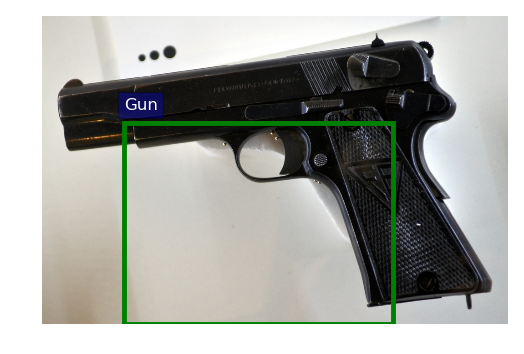

In [4]:
#CLASSES = ["car", "person", "bus", "van", "truck", "scooter", "bike", "pickup"]

#CLASSES = ['__background__','Shotgun', 'Rifle', 'Handgun', 'Knife','Sword', 'Baseball bat', 'Backpack', 'Handbag', 'Suitcase', 'Luggage and bags']
CLASSES = ["__background__","Gun","Knife"]


#CLASSES = ["__background__","Backpack", "Baseball bat", "Baseball glove",  "Bicycle", 
#            "Shotgun", "Handgun", "Suit", "Rifle", "Dress"]

    
cfg_from_file("models/pvanet/cfgs/submit_0716.yml")

prototxt = "/root/pva-faster-rcnn/models/pvanet/lite/weapon0826_test.prototxt"
caffemodel = "/root/pva-faster-rcnn/models/output/weapon0826/weapon0826_iter_48000.caffemodel"


GPU_ID = 1






if not os.path.isfile(caffemodel):
    raise IOError(('Caffemodel: {:s} not found').format(caffemodel))
caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
cfg.GPU_ID = GPU_ID
net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print '\n\nLoaded network {:s}'.format(caffemodel)

fileName = "dc84175596b5f4c7"

fileset = ["train","test","validation"]

for path in fileset:
    im_path = '/root/data/data-openImages_v4/{}/{}.jpg'.format(path,fileName) #human
    if os.path.isfile(im_path):
        break
        
#im_path = "/root/pva-faster-rcnn/Testing_weapon/1533631042984.jpg"        
im = cv2.imread(im_path)


print("PVANET Loaded")
print("Start Detecting")
# write_testing_results_file(net, imdb, FPS_rate, OUTPUT_DIR, classes)      
NMS_THRESH = 0.3
_t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
scores,boxes = im_detect(net,im,_t)
#print len(scores)
edgecolor = "green"
res = [] 
fig, ax = plt.subplots(figsize=(6, 6))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
plt.axis('off')
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    thresh = 0
    inds = np.where(dets[:, -1] > thresh)[0]
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]*100


        #Fix bug 6
        x = bbox[0]
        y = bbox[1]
        width = bbox[2] - bbox[0]
        height =  bbox[3] - bbox[1]
        label = cls
        socre = bbox[-1] * 100
        
        #if label in TARGET_CLASSES:
        if score > 60:
            print ("{},{},{},{},{},{},{}\n".format(im_path, x, y, width, height, score, label))
            res.append([im_path, x, y, width, height, score, label])

            
            
for i in res:
    ax.add_patch(plt.Rectangle((i[1], i[2]),i[3],i[4], fill=False,edgecolor=edgecolor, linewidth=3.5))
    ax.text(i[1], i[2] - 30,'{:s}'.format(i[6]),bbox=dict(facecolor='blue', alpha=0.3),fontsize=12, color='white')
                 
plt.show()
#print score,boxes


#%timeit im_detect(net,im,_t)

In [ ]:
#caffemodel = '/root/pva-faster-rcnn/models/output/weaponModel_0726/weaponModel_0726_iter_40.caffemodel'
#caffemodel2 = "/root/pva-faster-rcnn/models/output/weaponModel_2class/weaponModel_2class_iter_22000.caffemodel"
caffemodel2 = '/root/pva-faster-rcnn/models/output/weapon0806/weapon0806_iter_44000.caffemodel'
#caffemodel2 = "/root/pva-faster-rcnn/models/output/weapon_2class_random/weapon_2class_random_iter_30000.caffemodel"
#prototxt2 = '/root/pva-faster-rcnn/models/pvanet/lite/weaponModel_0723_test.prototxt'
#caffemodel2 = '/root/pva-faster-rcnn/models/output/weaponModel_0723/weaponModel_0723_iter_56000.caffemodel'

#net = caffe.Net(prototxt, caffemodel, caffe.TEST)

#caffemodel2 = '/root/pva-faster-rcnn/models/output/humanType_new/humanType_new_iter_148000.caffemodel'
net2 = caffe.Net(prototxt, caffemodel2, caffe.TEST)




print net.params['bbox_pred-coco'][0].data
print "====================="

print net2.params['bbox_pred-coco'][0].data

In [ ]:
dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
keep = nms(dets, 0.2)
dets = dets[keep, :]

In [ ]:
a = ['guin']

In [ ]:
valutionTool.py
新增
API:
1. evaluate
- params:
 required:
   type_list
   model
   prototxt
   gpu_id
 optional: 
   dataset
- return:
  {'<type>': {'recall': <value>, 'precision': <value>}}